## TRI HYSPLIT Modeling: Descriptive Analysis

Greg Lee
<br> 03.03.2020

# Toxic Release Inventory Data Background

**WHAT IS THE TRI** 
<br>TRI tracks the management of certain toxic chemicals that may pose a threat to human health and the environment. U.S. facilities in different industry sectors must report annually how much of each chemical is released to the environment and/or managed through recycling, energy recovery and treatment. (A "release" of a chemical means that it is emitted to the air or water, or placed in some type of land disposal.) [1]

**WHICH CHEMICALS AND COMPANIES ARE REQUIRED TO REPORT?**
- Have 10 or more full-time employee equivalents
- Facility is included in the following NAICS codes:
    - Manufacturing of: food, beverage, apparel, leather, wood, paper, petroleum, coal, chemical, plastics, rubber, minerals, metals, machinery, computers, electronics, applicance, transportation, furniture and more. 
- Facility uses chemical in quanitities greater than establihed threshold in the course of a calendar year. (changes year to year)

**WHEN WAS THE PROGRAM STARTED**
<br>In 1986, Congress passed the Emergency Planning and Community Right-to-Know Act (EPCRA) to support and promote emergency planning and to provide the public with information about releases of toxic chemicals in their community. Section 313 of EPCRA established the Toxics Release Inventory. Data is collected on a yearly basis. 

[1] - https://www.epa.gov/toxics-release-inventory-tri-program/what-toxics-release-inventory
<br>[2] - https://www.epa.gov/toxics-release-inventory-tri-program/tri-covered-industry-sectors 

# Data Import

In [1]:
#USE geo env!

#Basic py: 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import os
import math

#Vis
import seaborn as sns

#Geo
import geopandas as gpd
import fiona
from shapely.geometry import Point
import descartes
import contextily as ctx #Basemaps 

In [2]:
#Import all data and merge into one dataframe
path = "./Toxic_Release_Inventory" 
for index, files in enumerate(os.listdir(path)):
    temp_df = pd.read_csv(path + "/" + files)

    #Columns are standard, merge the dataset on that
    if index == 0:
        tri_df = temp_df
        print('check')
    else:
        tri_df = tri_df.append(temp_df)
        
#Clean up the data
tri_df.rename(columns=lambda x: ' '.join(x.split('.')[1:]), inplace=True)
tri_df.rename(columns=lambda x: x.replace(' ',''), inplace=True)

#Select the data from 1990-1999 which is air pollution
select_tri = tri_df.loc[(tri_df['YEAR']>=1990) & (tri_df["YEAR"] < 2000)]

select_tri_air = select_tri[(select_tri['51-FUGITIVEAIR']>0) | (select_tri['52-STACKAIR']>0)]
print("From 1990-1999 there are {0} data entries and {1} features".format(select_tri.shape[0],select_tri.shape[1]))

check
From 1990-1999 there are 5733 data entries and 114 features


The loaded shape of the data is what we expect. The 114 features represent details about the location, industry and toxin. For more information on this, please visit the EPAs website (https://www.epa.gov/toxics-release-inventory-tri-program/descriptions-tri-data-terms#popup_1)

# Data Cleaning

In [3]:
#Percentage of data missing values
pd.set_option('display.max_rows', 500)
print(select_tri_air.isna().sum().sort_values()/select_tri_air.shape[0])

YEAR                       0.000000
62-M26                     0.000000
62-M24                     0.000000
62-M20                     0.000000
OFF-SITERELEASETOTAL       0.000000
62-M99                     0.000000
62-M94                     0.000000
62-M90                     0.000000
62-M79                     0.000000
62-M73                     0.000000
62-M65                     0.000000
62-M64                     0.000000
62-M67                     0.000000
62-M66                     0.000000
62-M63                     0.000000
62-M72                     0.000000
62-M82                     0.000000
62-M81                     0.000000
62-M71                     0.000000
62-M61METAL                0.000000
62-M40METAL                0.000000
62-M62                     0.000000
62-M41                     0.000000
62-M10                     0.000000
62-M28                     0.000000
62-M93                     0.000000
OFF-SITERECYCLEDTOTAL      0.000000
62-M56                     0

Examination of the missing values showcases the highest number of missing values are found in the NAIC and SIC codes. This makes sense, as not all companies had multiple codes. Additionally, approximately 23% of the data is missing parent company data and binary release data. 

We will only keep data for which there is less than 5% of missing data. 

In [4]:
clean_index = select_tri_air.isna().sum()<math.floor(select_tri_air.shape[0]*0.05)
select_tri_air_clean = select_tri_air.loc[:,clean_index.index[clean_index==True]]

#Let's collect and analyze a subset of the data which focuses on TRI air releases
select_tri_air_clean = select_tri_air_clean[['YEAR','TRIFD','FACILITYNAME','CITY','COUNTY','ST','ZIP','LATITUDE','LONGITUDE',
                           'INDUSTRYSECTORCODE','INDUSTRYSECTOR','CHEMICAL','CAS#/COMPOUNDID','METAL','CARCINOGEN' ,
                           'UNITOFMEASURE','51-FUGITIVEAIR','52-STACKAIR','TOTALRELEASES']]

## Selecting IARC Labelled "Known" Carcinogens

The international agency for research on cancer created a listing of carcinogens with varying confidence. While the TRI data contains a carcinogen column, we decided to use the IARC classifications for chemical filtering. We find this measure to be more conservative. 

Ratings: 
<br>1 - Known Carcinogen
<br>2A - Probably carcinogenic to humans
<br>2B - Possibly carcinogenic to humans
<br>3 - not classifiable as to its carcinogenicity to humans

In [5]:
#Import the IARC Data
iarc_df = pd.read_csv('IARC_Class_Full_List.csv')

#Standardize the Column Names
iarc_df.rename(columns=lambda x: x.replace(' ','_'), inplace=True)
iarc_df.rename(columns=lambda x: x.replace('.',''), inplace=True)

#The CAS numbers are not standardized between groups. Let's change that!
#A CASRN contains a first number (2-7 digits) - second number (2 digits) - third number - 1 digit=
iarc_df.CAS_No = iarc_df.CAS_No.str.replace('-','').apply('{:0>9}'.format)
iarc_df.CAS_No = iarc_df.CAS_No.str.replace('000000nan',str(np.nan))

print("There are {0} chemicals with {1} features".format(iarc_df.shape[0],iarc_df.shape[1]))

There are 1079 chemicals with 6 features


In [6]:
#Select those chemicals with a 1,2A or 2B designation (KNOWN CARCINOGENS)
known_carc = iarc_df[iarc_df.Group != "3"]
#Merge the data
carc_sel_tri_air = known_carc.merge(select_tri_air_clean, 
                                    left_on='CAS_No', 
                                    right_on='CAS#/COMPOUNDID',
                                    how='inner')

print("Data are present from {0} to {1}".format(carc_sel_tri_air['YEAR'].min(),carc_sel_tri_air['YEAR'].max()))
print("There are {0} total observations in the data".format(carc_sel_tri_air.shape[0]))

Data are present from 1990 to 1999
There are 900 total observations in the data


In [7]:
#Fix those entries which have a "see xx (other chemical)"
carc_sel_tri_air.loc[carc_sel_tri_air.Agent== "Strong-inorganic-acid mists containing sulfuric acid (see Acid mists)",
       'Group'] = '1'

carc_sel_tri_air.loc[carc_sel_tri_air.Agent== "Bis(2-ethylhexyl) phthalate (see Di(2-ethylhexyl) phthalate)",
       'Group'] = '2B'

#Clean up unnessessary/unusable information
carc_sel_tri_air = carc_sel_tri_air.drop(columns=['CAS_No','Agent','Volume', 'Year', 'Additional_information'])

Text(0.5, 1.0, 'Histogram of TRI Carcinogenic Status')

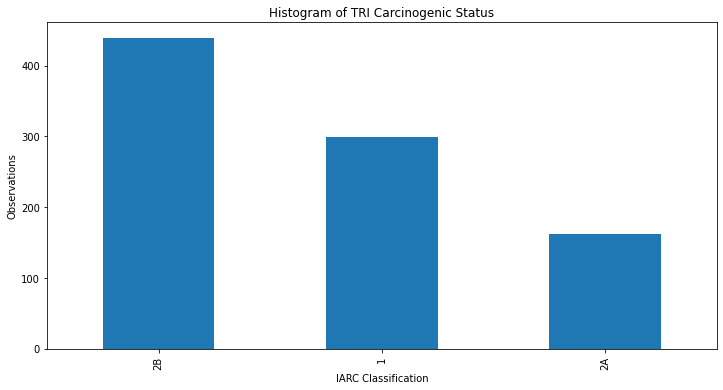

In [11]:
#Histogram: total number of chemicals per each IARC bin 
fig,ax = plt.subplots(1,1,figsize=(12,6))
ax = carc_sel_tri_air['Group'].value_counts().plot.bar()
ax.set_xlabel('IARC Classification')
ax.set_ylabel('Observations')
ax.set_title('Histogram of TRI Carcinogenic Status')

# Descriptive Analysis

In [12]:
#Unique locations and chemicals
uniq_locs = carc_sel_tri_air.groupby(['LATITUDE', 'LONGITUDE']).size().reset_index(name='Freq')
uniq_chems = carc_sel_tri_air.groupby(['CAS#/COMPOUNDID']).size().reset_index(name='Freq')
print("There are a total of {0} unique locations".format(uniq_locs.shape[0]))
print("There are a total of {0} unique chemicals".format(uniq_chems.shape[0]))

There are a total of 113 unique locations
There are a total of 32 unique chemicals


In [13]:
#What are the most and least common chemicals
agg_chems =carc_sel_tri_air['CHEMICAL'].value_counts()
print("Most common chemical")
print(agg_chems.head(5))

print("\nLeast common chemicals")
print(agg_chems.tail(5))

Most common chemical
SULFURIC ACID (1994 AND AFTER ACID AEROSOLS" ONLY)"    137
NICKEL                                                  97
STYRENE                                                 84
BENZENE                                                 82
NAPHTHALENE                                             73
Name: CHEMICAL, dtype: int64

Least common chemicals
DIETHANOLAMINE             2
PENTACHLOROPHENOL          2
CHLOROFORM                 2
4,4'-METHYLENEDIANILINE    1
N,N-DIMETHYLFORMAMIDE      1
Name: CHEMICAL, dtype: int64


### Distributions: Year and County

In [24]:
temp=carc_sel_tri_air
temp['sumer'] = 1
temp.groupby(['COUNTY']).agg({'sumer': 'sum'}).reset_index()

,COUNTY,sumer
0,BOX ELDER,23
1,CACHE,17
2,CARBON,1
3,DAVIS,165
4,DUCHESNE,20
5,EMERY,4
6,IRON,4
7,MILLARD,4
8,SALT LAKE,413
9,SANPETE,1


Text(0.5, 1.0, 'Histogram of TRI Occurences by County')

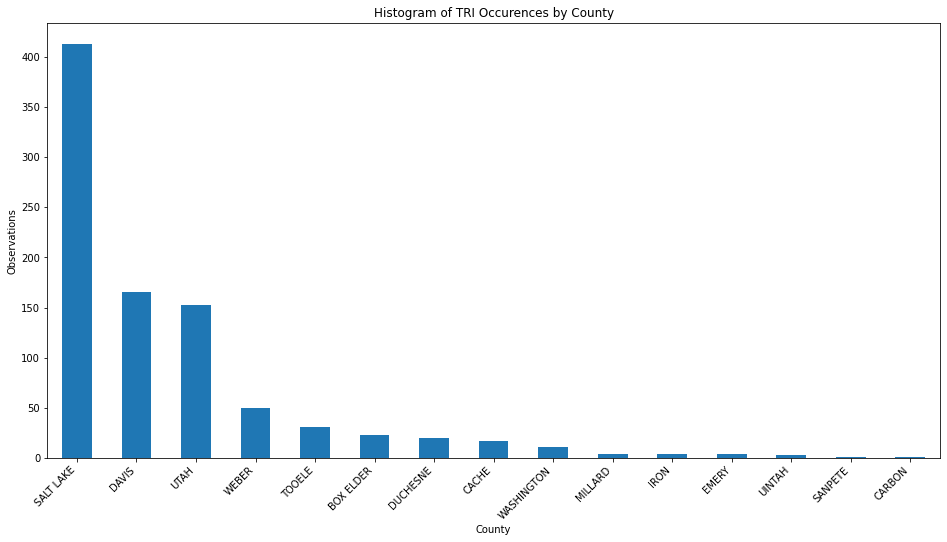

In [14]:
#Which Counties have the most observations? 
fig,ax = plt.subplots(1,1,figsize=(16, 8))
ax =  carc_sel_tri_air['COUNTY'].value_counts().plot.bar()
ax.set_xticklabels(carc_sel_tri_air['COUNTY'].value_counts().index, rotation = 45, ha="right")
ax.set_xlabel('County')
ax.set_ylabel('Observations')
ax.set_title('Histogram of TRI Occurences by County')

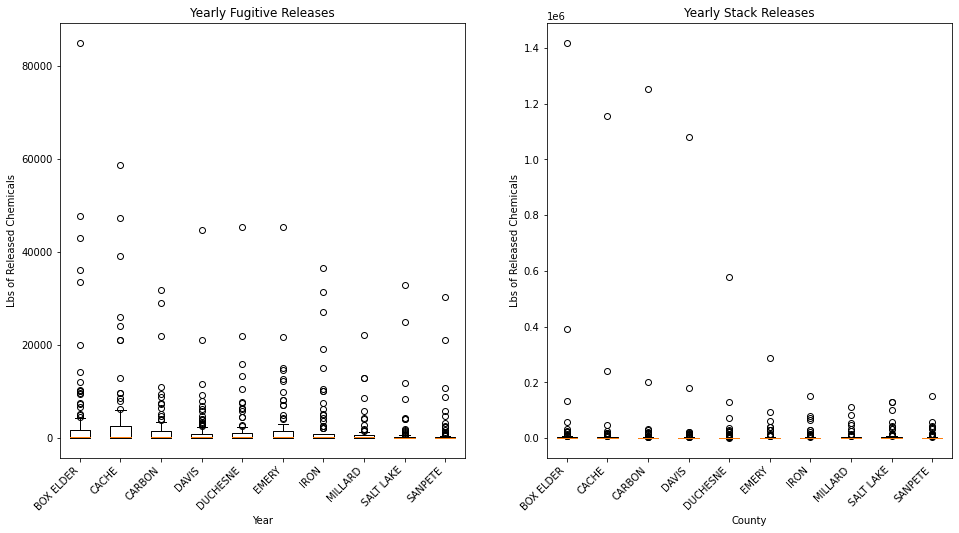

In [15]:
#Per year, how do the pounds of released material change? 

fig,ax = plt.subplots(1,2,figsize=(16, 8))

data = []
for year in sorted(carc_sel_tri_air['YEAR'].drop_duplicates()):
    d=carc_sel_tri_air[carc_sel_tri_air['YEAR']==year]['51-FUGITIVEAIR']
    data.append(d)
    
ax[0].boxplot(data)
ax[0].set_xticklabels(sorted(carc_sel_tri_air['COUNTY'].drop_duplicates()), rotation = 45, ha="right")
ax[0].set_xlabel('Year')
ax[0].set_ylabel('Lbs of Released Chemicals')
ax[0].set_title('Yearly Fugitive Releases')

data = []
for year in sorted(carc_sel_tri_air['YEAR'].drop_duplicates()):
    d=carc_sel_tri_air[carc_sel_tri_air['YEAR']==year]['52-STACKAIR']
    data.append(d)
    
ax[1].boxplot(data)
ax[1].set_xticklabels(sorted(carc_sel_tri_air['COUNTY'].drop_duplicates()), rotation = 45, ha="right")
ax[1].set_xlabel('County')
ax[1].set_ylabel('Lbs of Released Chemicals')
ax[1].set_title('Yearly Stack Releases')

plt.show()
plt.show()

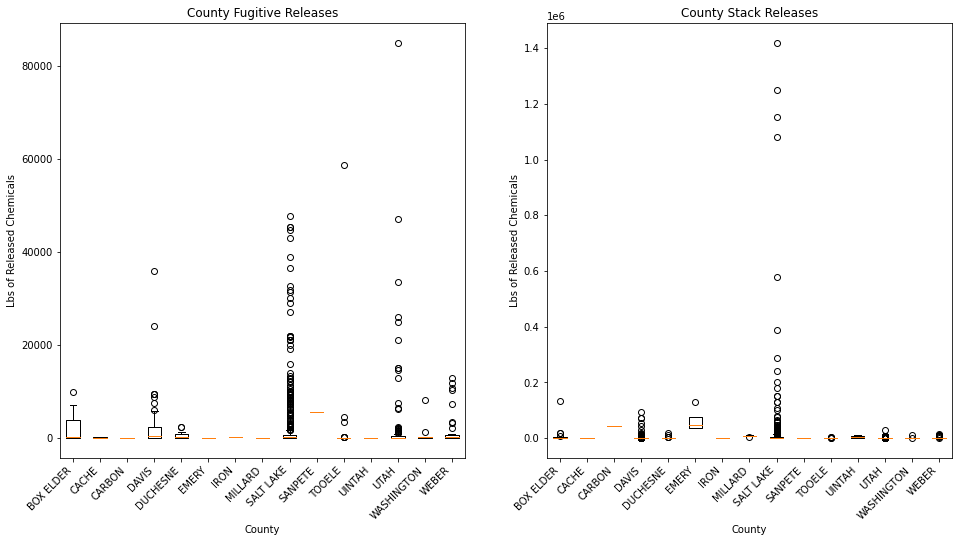

In [17]:
#Per county are the releases centered in any sort of manner?
fig,ax = plt.subplots(1,2,figsize=(16, 8))

data = []
for year in sorted(carc_sel_tri_air['COUNTY'].drop_duplicates()):
    d=carc_sel_tri_air[carc_sel_tri_air['COUNTY']==year]['51-FUGITIVEAIR']
    data.append(d)
    
ax[0].boxplot(data)
ax[0].set_xticklabels(sorted(carc_sel_tri_air['COUNTY'].drop_duplicates()), rotation = 45, ha="right")
ax[0].set_xlabel('County')
ax[0].set_ylabel('Lbs of Released Chemicals')
ax[0].set_title('County Fugitive Releases')

data = []
for year in sorted(carc_sel_tri_air['COUNTY'].drop_duplicates()):
    d=carc_sel_tri_air[carc_sel_tri_air['COUNTY']==year]['52-STACKAIR']
    data.append(d)
    
ax[1].boxplot(data)
ax[1].set_xticklabels(sorted(carc_sel_tri_air['COUNTY'].drop_duplicates()), rotation = 45, ha="right")
ax[1].set_xlabel('County')
ax[1].set_ylabel('Lbs of Released Chemicals')
ax[1].set_title('County Stack Releases')

plt.show()

### Visualization of TRI Releases